In [31]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera, kstest, anderson, f_oneway, levene, bartlett, kruskal, ttest_ind
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from pandas.tseries.offsets import Week
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from fitter import Fitter


In [3]:
data = pd.read_csv("wig20_d.csv")

In [4]:
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values('Data').reset_index(drop=True)
data = data.set_index("Data").sort_index()
all_days = pd.date_range(data.index.min(), data.index.max(), freq="B")
data = data.reindex(all_days)
data["Zamkniecie"] = data["Zamkniecie"].ffill()

returns = data['Zamkniecie'].pct_change().dropna()

In [6]:
# Oddzielamy ostatnią obserwację do weryfikacji prognozy
returns_train = returns[:-1]
returns_test = returns[-1:]

<Axes: title={'center': 'Dzienne zwroty WIG20'}>

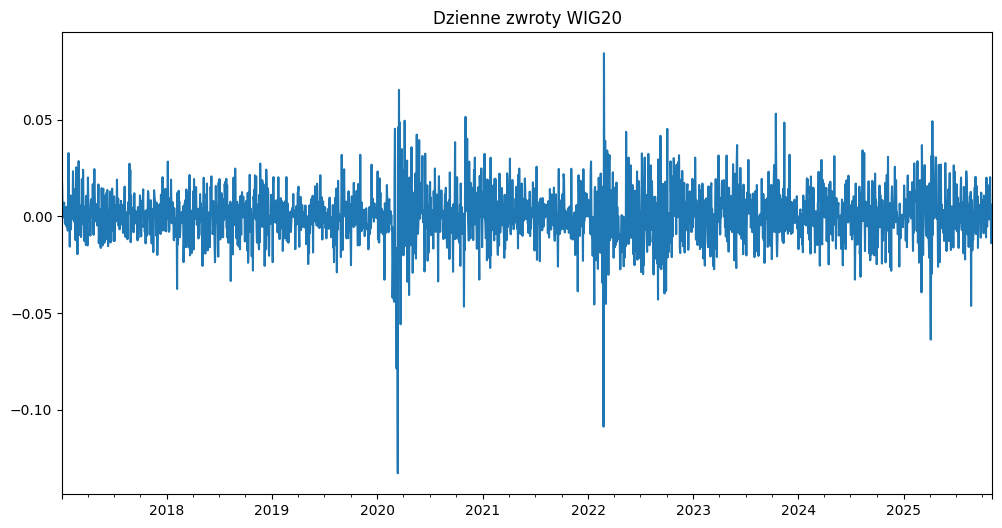

In [10]:
returns.plot(title='Dzienne zwroty WIG20', figsize=(12, 6))

In [11]:
# Statystyki opisowe
X = returns_train.values
X_mean = X.mean()
n = len(X)

print(f"\nPodstawowe statystyki:")
print(f"  N =                {n}")
print(f"  Średnia:           {X_mean:.2f} ")
print(f"  Mediana:           {np.median(X):.2f} ")
print(f"  Odch. standardowe: {np.std(X, ddof=1):.2f} ")
print(f"  Minimum:           {X.min():.2f} ")
print(f"  Maksimum:          {X.max():.2f} ")
print(f"  Rozstęp:           {X.max() - X.min():.2f} ")
print(f"  Skośność:          {stats.skew(X):.3f}")
print(f"  Kurtoza:           {stats.kurtosis(X):.3f}")


Podstawowe statystyki:
  N =                2305
  Średnia:           0.00 
  Mediana:           0.00 
  Odch. standardowe: 0.01 
  Minimum:           -0.13 
  Maksimum:          0.08 
  Rozstęp:           0.22 
  Skośność:          -0.483
  Kurtoza:           7.328


In [19]:

# 1) Test ADF (Augmented Dickey–Fuller)
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(returns_train, autolag='AIC')
print("\nTest ADF:")
print(f"  statystyka = {adf_stat:.4f}")
print(f"  p-value    = {adf_p:.4f}")
print(f"  Krytyczne wartości: {adf_crit}")


Test ADF:
  statystyka = -11.1670
  p-value    = 0.0000
  Krytyczne wartości: {'1%': -3.433215059686721, '5%': -2.862805715808642, '10%': -2.5674437983902245}


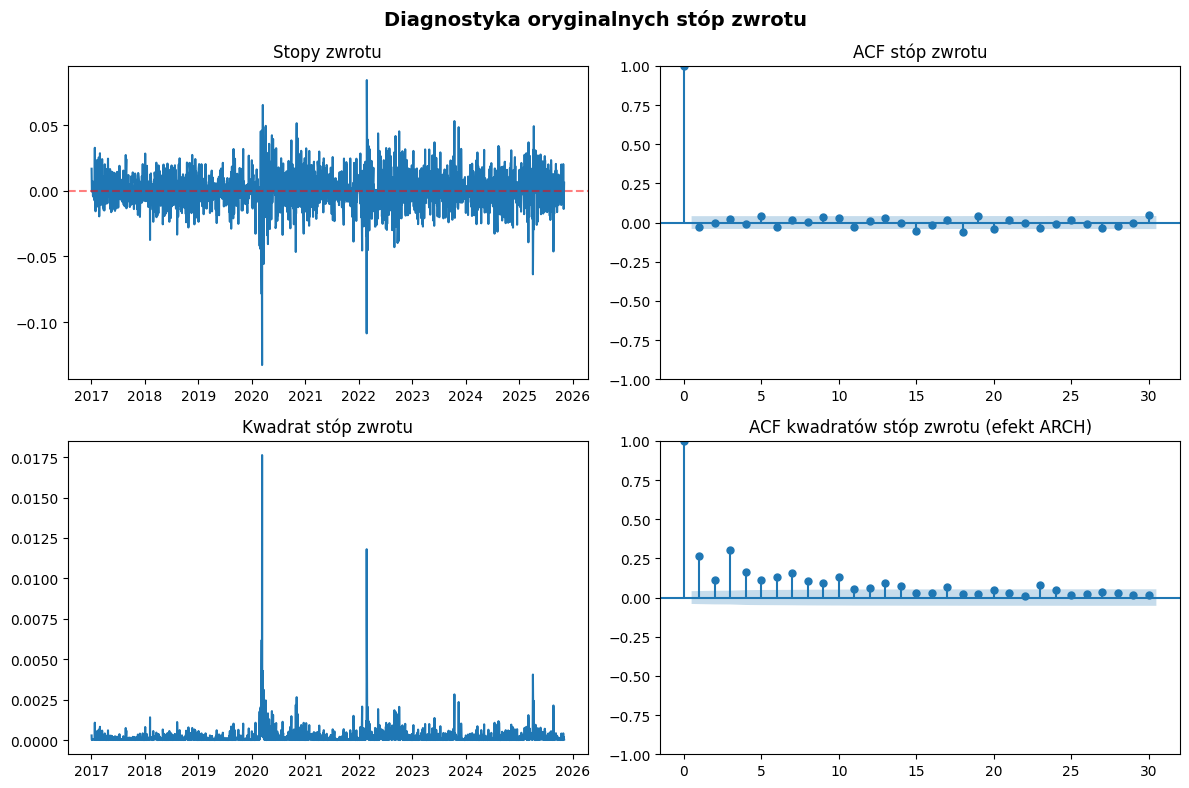

In [23]:
# Wykresy ACF i PACF dla oryginalnych danych
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Diagnostyka oryginalnych stóp zwrotu', fontsize=14, fontweight='bold')

axes[0, 0].plot(returns_train)
axes[0, 0].set_title('Stopy zwrotu')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plot_acf(returns_train, lags=30, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('ACF stóp zwrotu')

axes[1, 0].plot(returns_train**2)
axes[1, 0].set_title('Kwadrat stóp zwrotu')

plot_acf(returns_train**2, lags=30, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF kwadratów stóp zwrotu (efekt ARCH)')

plt.tight_layout()
plt.show()

In [14]:
arma_selector = arma_order_select_ic(
    returns_train, 
    ic=['aic', 'bic'],
    max_ar=5,
    max_ma=5,
    trend='c'  # ze stałą
)

best_order_aic = arma_selector['aic_min_order']
best_order_bic = arma_selector['bic_min_order']

print(f"\nNajlepszy rząd według AIC: ARMA{best_order_aic}")
print(f"Najlepszy rząd według BIC: ARMA{best_order_bic}")

# Używamy rzędu z BIC (bardziej konserwatywny)
p_order, q_order = best_order_bic
print(f"\n✓ Wybrany rząd (według BIC): ARMA({p_order}, {q_order})")


Najlepszy rząd według AIC: ARMA(0, 0)
Najlepszy rząd według BIC: ARMA(0, 0)

✓ Wybrany rząd (według BIC): ARMA(0, 0)


                               SARIMAX Results                                
Dep. Variable:             Zamkniecie   No. Observations:                 2305
Model:                          ARIMA   Log Likelihood                6599.113
Date:                Wed, 05 Nov 2025   AIC                         -13194.226
Time:                        13:55:42   BIC                         -13182.740
Sample:                    01-03-2017   HQIC                        -13190.039
                         - 11-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.950      0.342      -0.000       0.001
sigma2         0.0002   2.64e-06     72.345      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.59   Jarque-

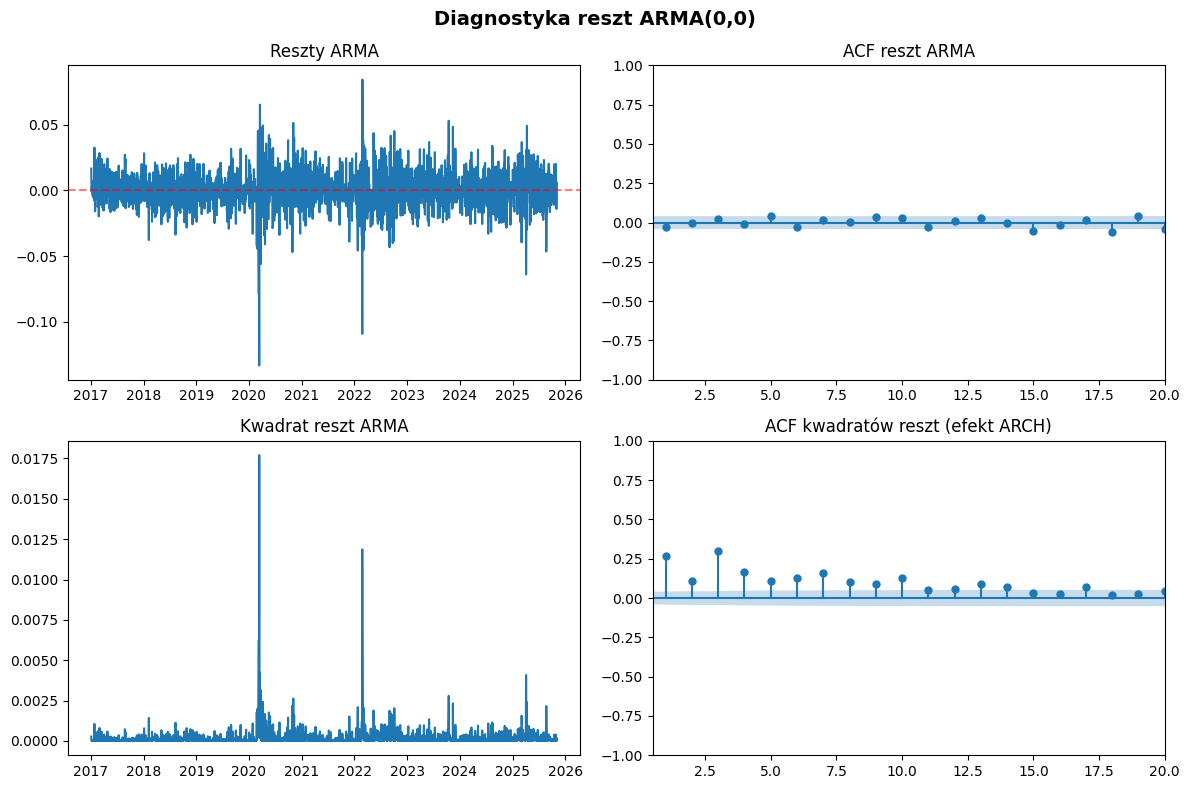

In [29]:
arma_model = ARIMA(returns_train, order=(p_order, 0, q_order), trend='c')
arma_fit = arma_model.fit()
print(arma_fit.summary())

# Reszty z modelu ARMA
arma_residuals = arma_fit.resid

# Diagnostyka reszt ARMA
print("\n--- Diagnostyka reszt ARMA ---")
lb_test_arma = acorr_ljungbox(arma_residuals, lags=10, return_df=True)
print(f"Test Ljung-Box dla reszt ARMA (lag 10): p = {lb_test_arma['lb_pvalue'].iloc[-1]}")

lb_test_arma_sq = acorr_ljungbox(arma_residuals**2, lags=10, return_df=True)
print(f"Test Ljung-Box dla kwadratów reszt (efekt ARCH, lag 10): p = {lb_test_arma_sq['lb_pvalue'].iloc[-1]}")

# Test Engle’a — sprawdza efekt ARCH w resztach ARMA
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(arma_residuals, nlags=10)

print("=== Test Engle’a (ARCH LM test) ===")
print(f"Statystyka LM: {lm_stat:.4f}")
print(f"p-wartość LM: {lm_pvalue:}")
print(f"Statystyka F: {f_stat:.4f}")
print(f"p-wartość F: {f_pvalue:}")

# Wykresy reszt ARMA
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle(f'Diagnostyka reszt ARMA({p_order},{q_order})', fontsize=14, fontweight='bold')

axes[0, 0].plot(arma_residuals)
axes[0, 0].set_title('Reszty ARMA')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plot_acf(arma_residuals, lags=30, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_xlim(0.5, 20)
axes[0, 1].set_title('ACF reszt ARMA')

axes[1, 0].plot(arma_residuals**2)
axes[1, 0].set_title('Kwadrat reszt ARMA')

plot_acf(arma_residuals**2, lags=30, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_xlim(0.5, 20)
axes[1, 1].set_title('ACF kwadratów reszt (efekt ARCH)')

plt.tight_layout()
plt.show()


************************************************************
Model: ARMA(0,0)-GARCH(1,1) z rozkładem normal
************************************************************
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6794.62
Distribution:                  Normal   AIC:                          -13583.2
Method:            Maximum Likelihood   BIC:                          -13566.0
                                        No. Observations:                 2305
Date:                Wed, Nov 05 2025   Df Residuals:                     2305
Time:                        14:26:45   Df Model:                            0
                              Volatility Model                              
                 coef    std err          

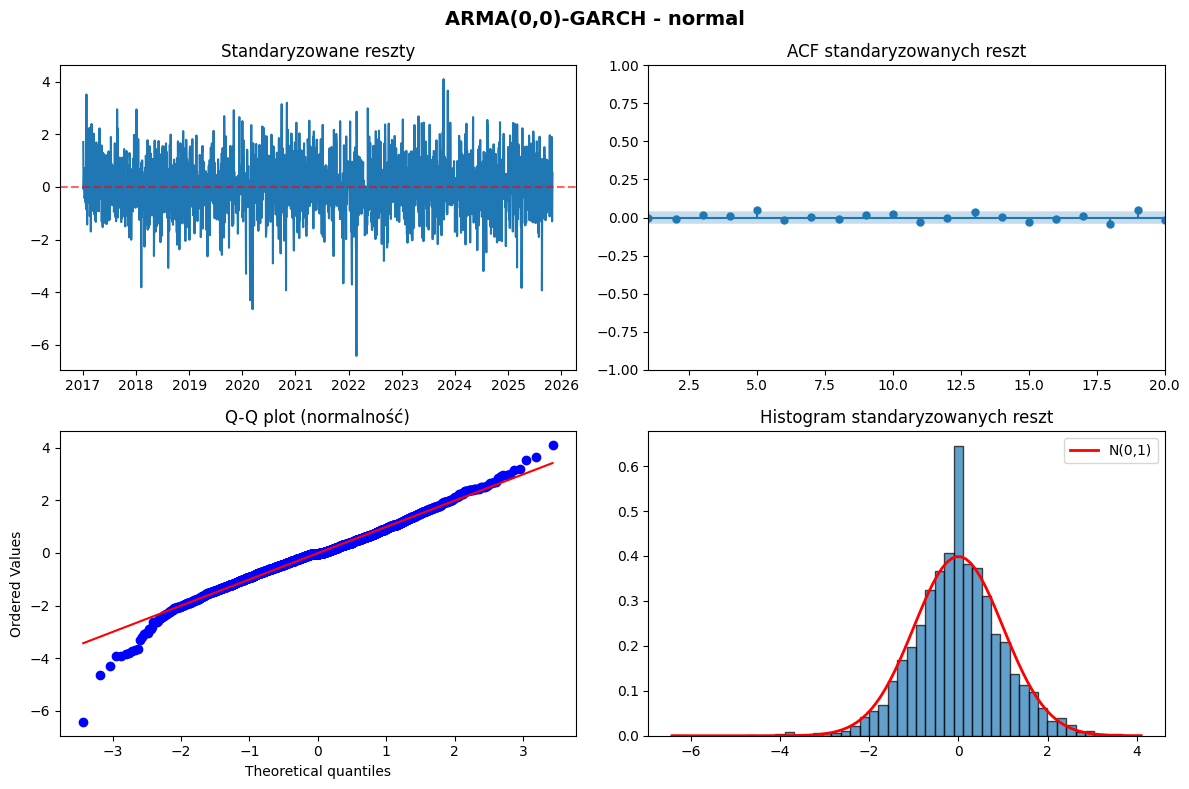


************************************************************
Model: ARMA(0,0)-GARCH(1,1) z rozkładem studentst
************************************************************
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                6840.11
Distribution:      Standardized Student's t   AIC:                          -13672.2
Method:                  Maximum Likelihood   BIC:                          -13649.2
                                              No. Observations:                 2305
Date:                      Wed, Nov 05 2025   Df Residuals:                     2305
Time:                              14:26:46   Df Model:                            0
                              Volatility Model                

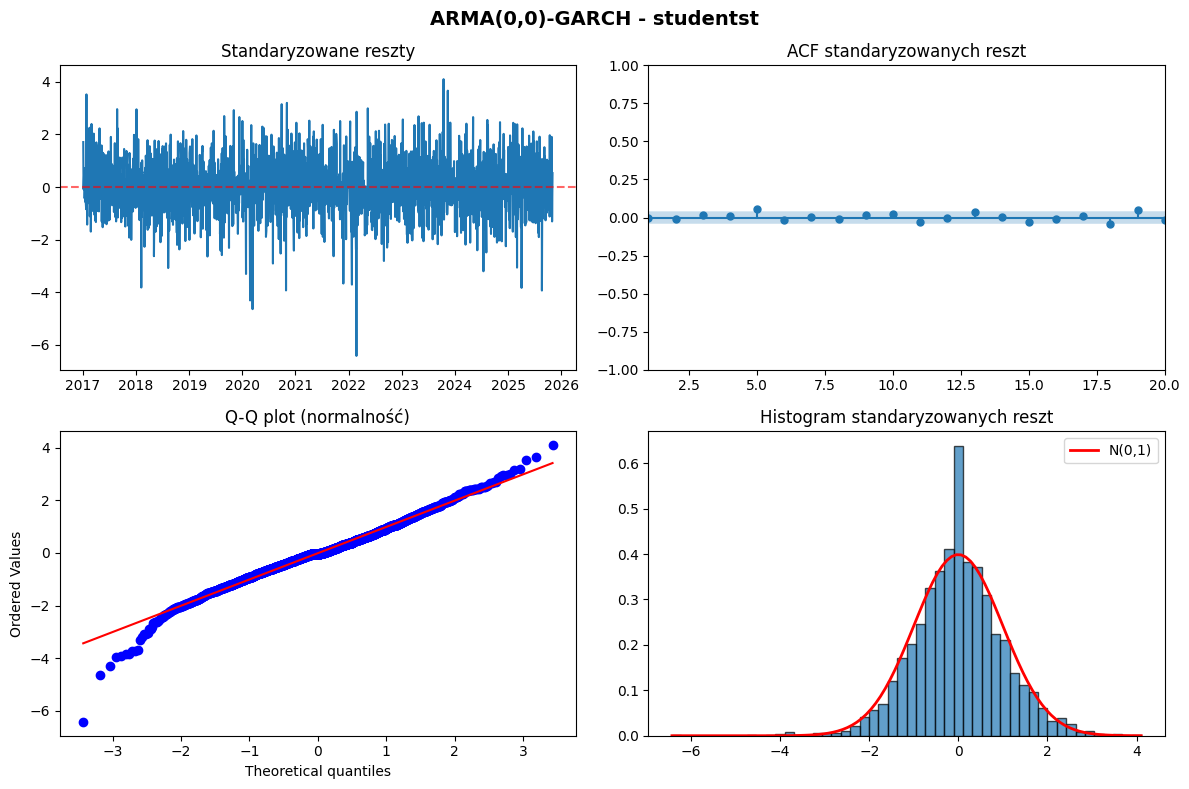


************************************************************
Model: ARMA(0,0)-GARCH(1,1) z rozkładem skewt
************************************************************
                             Zero Mean - GARCH Model Results                             
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                6840.49
Distribution:      Standardized Skew Student's t   AIC:                          -13671.0
Method:                       Maximum Likelihood   BIC:                          -13642.3
                                                   No. Observations:                 2305
Date:                           Wed, Nov 05 2025   Df Residuals:                     2305
Time:                                   14:26:46   Df Model:                            0
                     

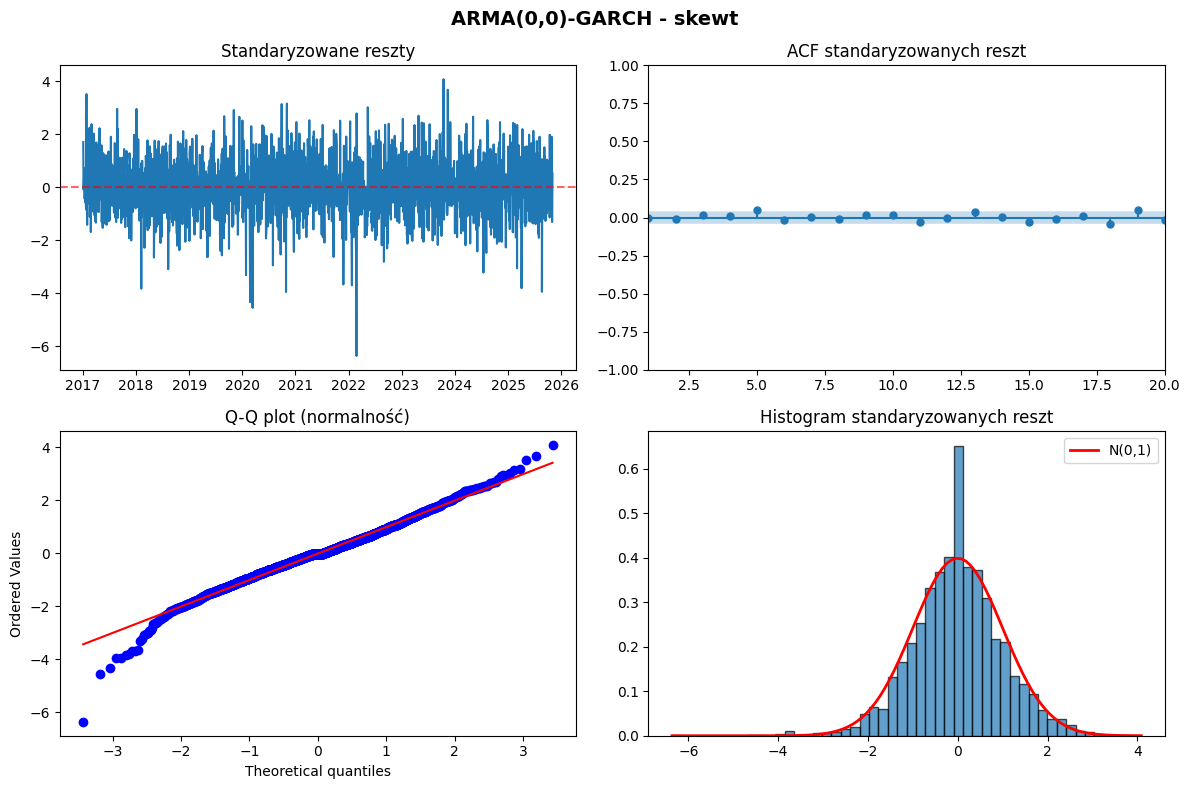


************************************************************
Model: ARMA(0,0)-EGARCH(1,1) z rozkładem normal
************************************************************
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                6793.70
Distribution:                  Normal   AIC:                          -13581.4
Method:            Maximum Likelihood   BIC:                          -13564.2
                                        No. Observations:                 2305
Date:                Wed, Nov 05 2025   Df Residuals:                     2305
Time:                        14:26:47   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t  

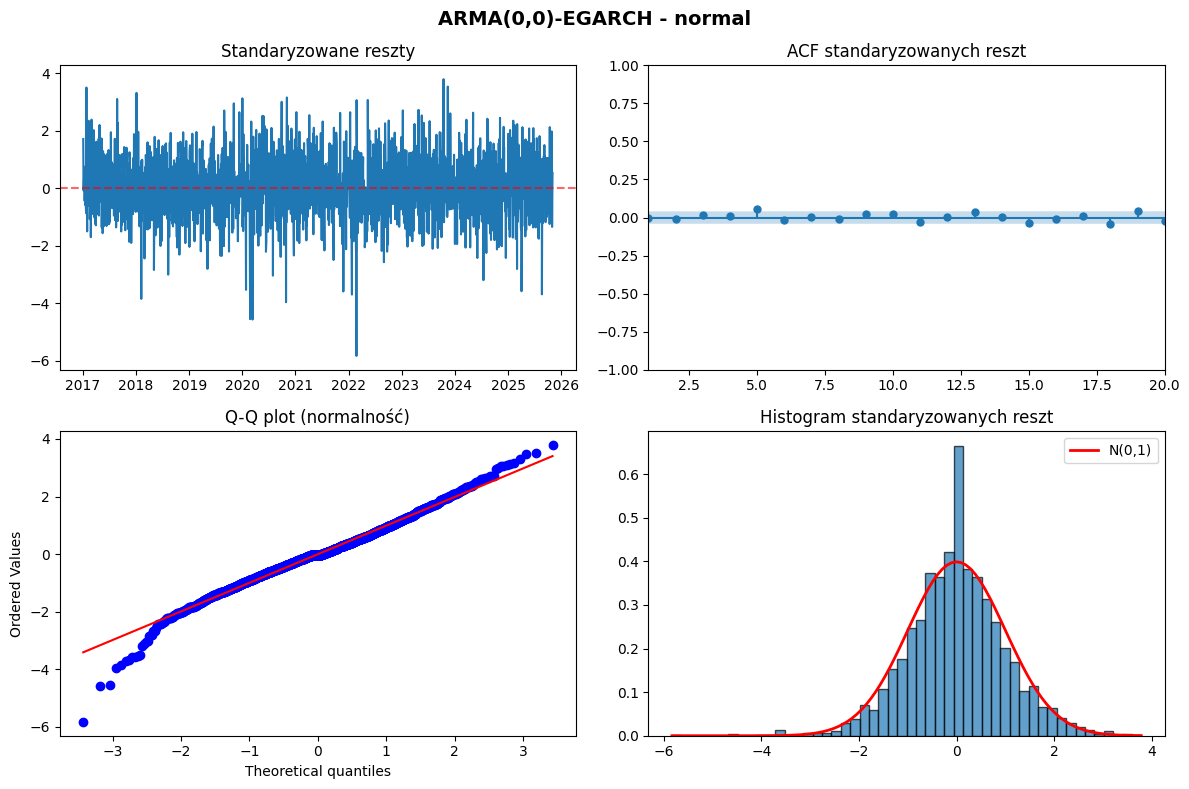


************************************************************
Model: ARMA(0,0)-EGARCH(1,1) z rozkładem studentst
************************************************************
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                6838.74
Distribution:      Standardized Student's t   AIC:                          -13669.5
Method:                  Maximum Likelihood   BIC:                          -13646.5
                                              No. Observations:                 2305
Date:                      Wed, Nov 05 2025   Df Residuals:                     2305
Time:                              14:26:47   Df Model:                            0
                              Volatility Model               

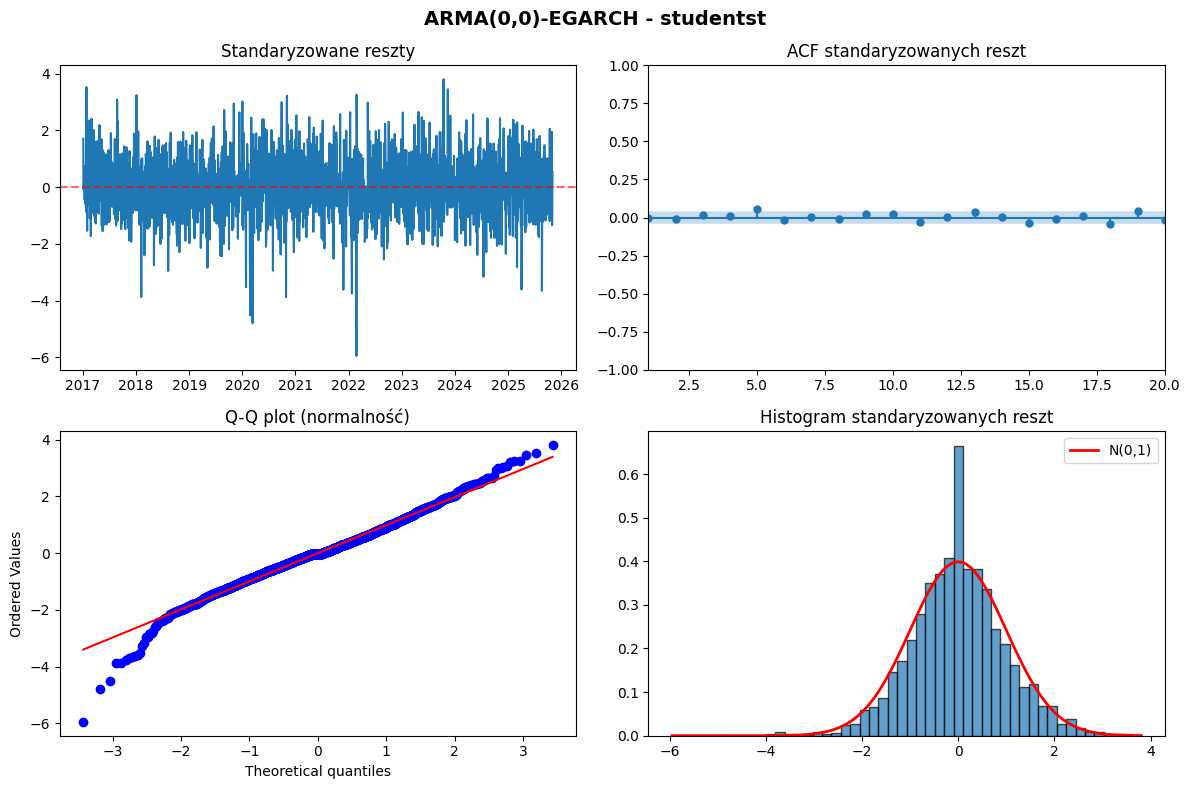


************************************************************
Model: ARMA(0,0)-EGARCH(1,1) z rozkładem skewt
************************************************************
                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:                6839.09
Distribution:      Standardized Skew Student's t   AIC:                          -13668.2
Method:                       Maximum Likelihood   BIC:                          -13639.5
                                                   No. Observations:                 2305
Date:                           Wed, Nov 05 2025   Df Residuals:                     2305
Time:                                   14:26:48   Df Model:                            0
                    

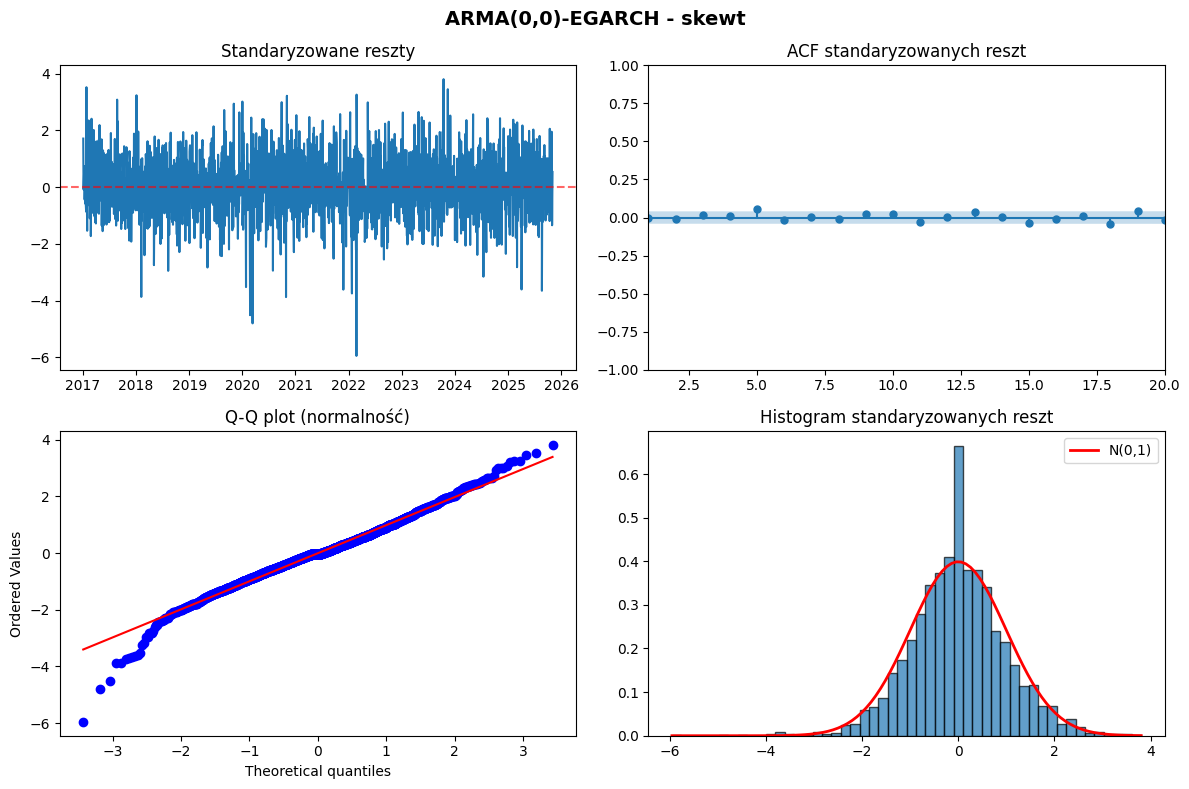


************************************************************
Model: ARMA(0,0)-GJR-GARCH(1,1) z rozkładem normal
************************************************************
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                6826.57
Distribution:                  Normal   AIC:                          -13645.1
Method:            Maximum Likelihood   BIC:                          -13622.2
                                        No. Observations:                 2305
Date:                Wed, Nov 05 2025   Df Residuals:                     2305
Time:                        14:26:48   Df Model:                            0
                               Volatility Model                              
                 coef    std err     

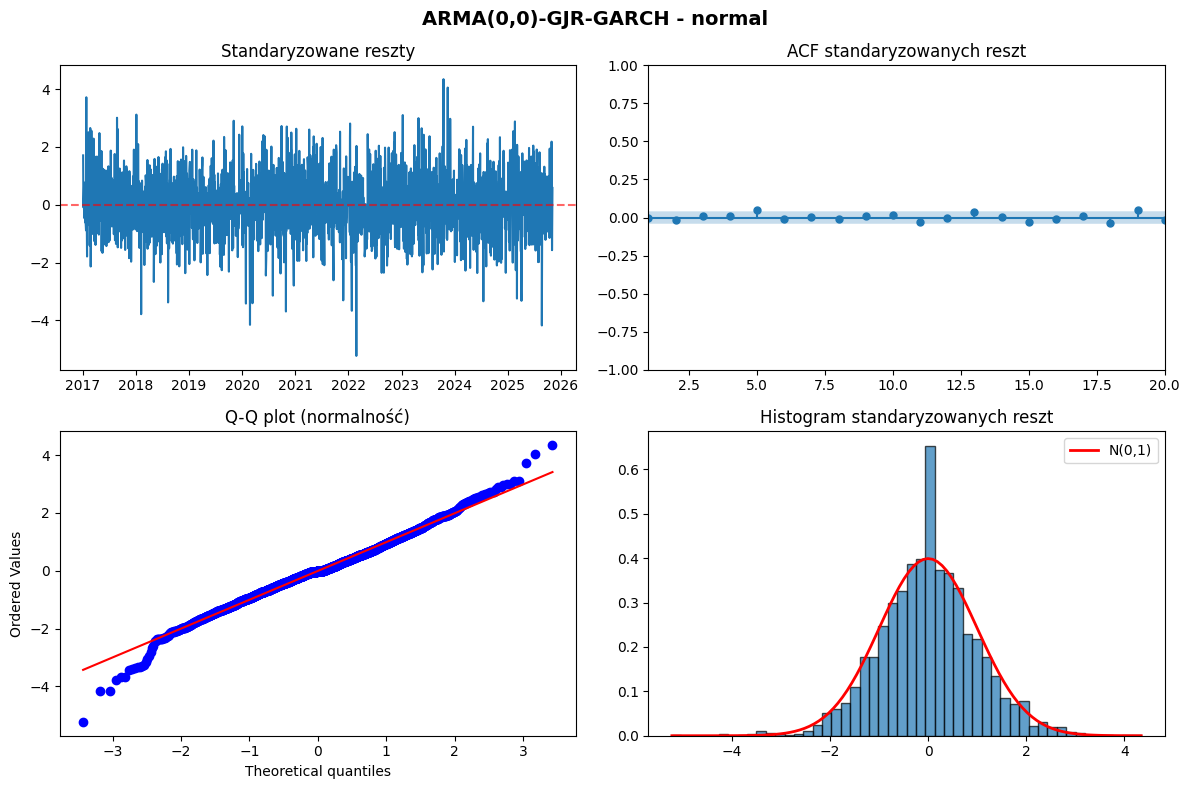


************************************************************
Model: ARMA(0,0)-GJR-GARCH(1,1) z rozkładem studentst
************************************************************
                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                6861.15
Distribution:      Standardized Student's t   AIC:                          -13712.3
Method:                  Maximum Likelihood   BIC:                          -13683.6
                                              No. Observations:                 2305
Date:                      Wed, Nov 05 2025   Df Residuals:                     2305
Time:                              14:26:49   Df Model:                            0
                               Volatility Model           

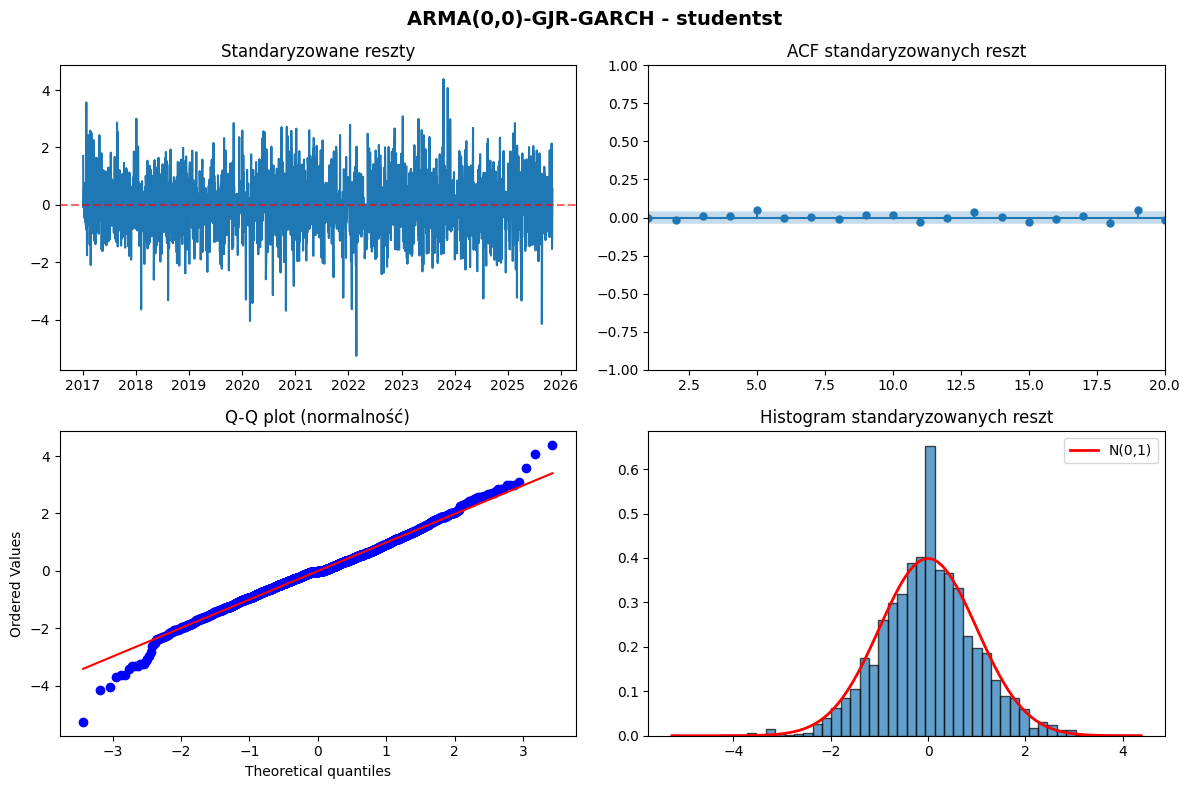


************************************************************
Model: ARMA(0,0)-GJR-GARCH(1,1) z rozkładem skewt
************************************************************
                           Zero Mean - GJR-GARCH Model Results                           
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:                6860.28
Distribution:      Standardized Skew Student's t   AIC:                          -13708.6
Method:                       Maximum Likelihood   BIC:                          -13674.1
                                                   No. Observations:                 2305
Date:                           Wed, Nov 05 2025   Df Residuals:                     2305
Time:                                   14:26:49   Df Model:                            0
                 

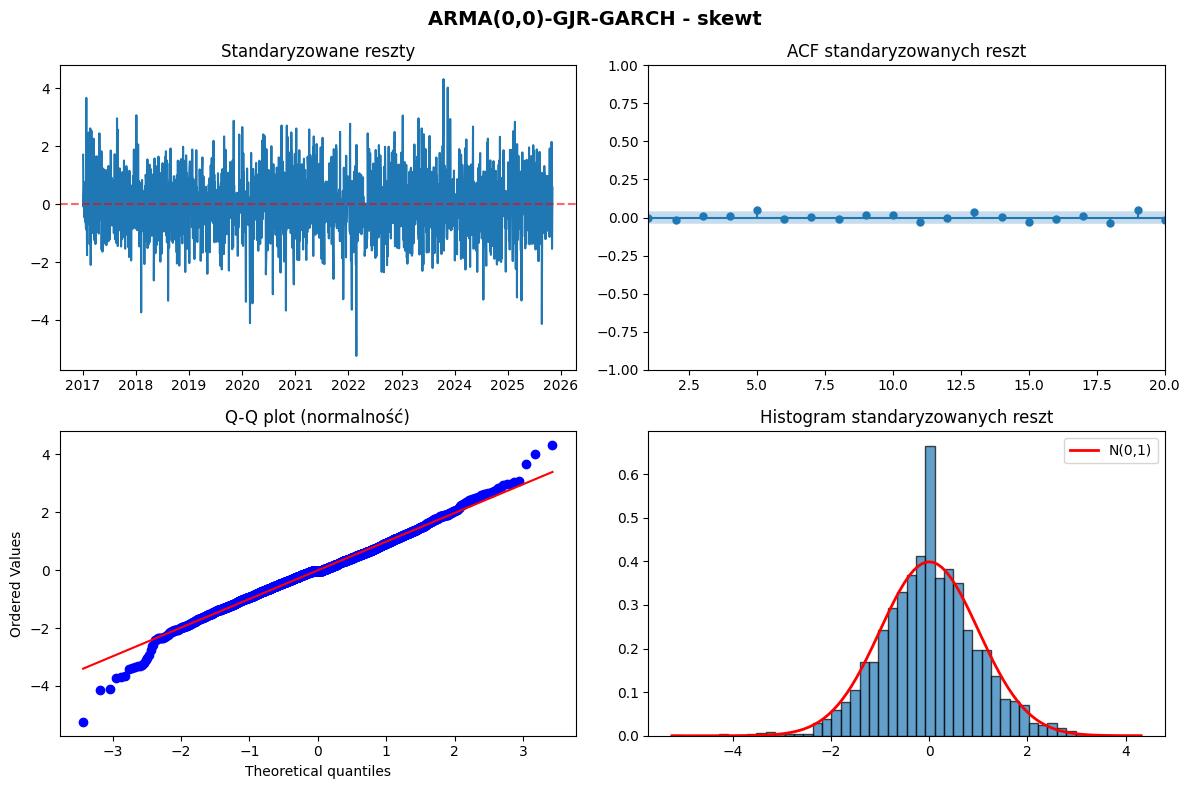

In [44]:

models_to_test = {
    'GARCH': {'vol': 'GARCH', 'o': 0},
    'EGARCH': {'vol': 'EGARCH', 'o': 0},
    'GJR-GARCH': {'vol': 'GARCH', 'o': 1}  # Uwaga: to jest GJR
}

distributions = ['normal', 'studentst', 'skewt']
results_summary = []

for model_name, model_params in models_to_test.items():
    for dist in distributions:
        print(f"\n{'*' * 60}")
        print(f"Model: ARMA({p_order},{q_order})-{model_name}(1,1) z rozkładem {dist}")
        print('*' * 60)
        
        try:
            # --- Dopasowanie modelu GARCH do reszt ARMA ---
            garch_model = arch_model(
                arma_residuals,
                mean='Zero',
                vol=model_params['vol'],
                p=1,
                o=model_params.get('o', 0),
                q=1,
                dist=dist,
                rescale=False
            )

            garch_fit = garch_model.fit(disp='off', show_warning=False)
            print(garch_fit.summary())
            
            # --- Standaryzowane reszty ---
            std_resid = garch_fit.std_resid.dropna()

            # ====================
            # TESTY DIAGNOSTYCZNE
            # ====================
            print("\n--- TESTY DIAGNOSTYCZNE ---")

            # 1. Test Ljung–Box na autokorelację reszt
            
            print("\n=== Test Ljung–Box ===")
            lb_test = acorr_ljungbox(std_resid, lags=10, return_df=True)
            lb_pval = lb_test['lb_pvalue'].iloc[-1]
            print(f"Ljung-Box (reszty): p = {lb_pval:.4f} → {'✓ brak autokorelacji' if lb_pval>0.05 else '✗ autokorelacja'}")

            # 2. Test Ljung–Box na kwadratach reszt (efekt ARCH)
            lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=10)

            print("\n=== Test Engle’a (ARCH LM test) ===")
            print(f"Statystyka LM: {lm_stat:.4f}")
            print(f"p-wartość LM: {lm_pvalue:}")
            print(f"Statystyka F: {f_stat:.4f}")
            print(f"p-wartość F: {f_pvalue:}")

            print(f"{'✓ brak efektu ARCH' if lm_pvalue > 0.05 else '✗ efekt ARCH'}")

            # ====================
            # Rozkład empiryczny reszt
            # ====================
            print("\n=== Test Kołmogorowa-Smirnowa ===")
            if dist == 'normal':
                params = stats.norm.fit(std_resid)
                stat, p = stats.kstest(std_resid, 'norm', args=params)
                dist_name = 'Normalny'
            elif dist == 'studentst':
                params = stats.t.fit(std_resid)
                stat, p = stats.kstest(std_resid, 't', args=params)
                dist_name = 't-Studenta'
            elif dist == 'skewt':
                # scipy nie ma bezpośredniego skew-t, więc testujemy skośny normalny
                params = stats.skewnorm.fit(std_resid)
                stat, p = stats.kstest(std_resid, 'skewnorm', args=params)
                dist_name = 'Skośny normalny (proxy dla skew-t)'
            print(f"Rozkład testowany: {dist_name}")
            print(f"Parametry: {params}")
            print(f"Statystyka KS: {stat:.4f}, p-wartość: {p:.4f}")

            if p > 0.05:
                print(f"✓ Reszty zgodne z rozkładem {dist_name} (p > 0.05)")
            else:
                print(f"✗ Reszty niezgodne z rozkładem {dist_name} (p < 0.05)")
            # ====================
            # PROGNOZA
            # ====================
            arma_forecast = arma_fit.forecast(steps=1)
            mean_forecast = arma_forecast.iloc[0]
            
            garch_forecast = garch_fit.forecast(horizon=1, reindex=False)
            variance_forecast = garch_forecast.variance.iloc[-1, 0]
            std_forecast = np.sqrt(variance_forecast)

            if dist == 'normal':
                z_alpha = stats.norm.ppf(0.975)
            elif dist == 'studentst':
                nu = garch_fit.params.get('nu', 10)
                z_alpha = stats.t.ppf(0.975, nu)
            else:  # skewt
                nu = garch_fit.params.get('nu', 10)
                z_alpha = stats.t.ppf(0.975, nu)

            ci_lower = mean_forecast - z_alpha * std_forecast
            ci_upper = mean_forecast + z_alpha * std_forecast

            actual_value = returns_test.values[0]
            in_interval = ci_lower <= actual_value <= ci_upper

            print("\n--- PROGNOZA ---")
            print(f"Prognoza średniej (ARMA): {mean_forecast:.4f}")
            print(f"Prognoza std (GARCH): {std_forecast:.4f}")
            print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
            print(f"Rzeczywista wartość: {actual_value:.4f}")
            print(f"Czy w przedziale? {'✓ TAK' if in_interval else '✗ NIE'}")

            # --- Zapis wyników ---
            results_summary.append({
                'Model': f'ARMA({p_order},{q_order})-{model_name}',
                'Rozkład': dist,
                'AIC': garch_fit.aic,
                'BIC': garch_fit.bic,
                'LogLik': garch_fit.loglikelihood,
                'LB_pval': lb_test['lb_pvalue'].iloc[-1],
                'LB_sq_pval': lm_pvalue,
                'KS_pval': p,
                'W_przedziale': in_interval,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper,
                'Forecast': mean_forecast
            })
            # ====================
            # WYKRESY DIAGNOSTYCZNE
            # ====================
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle(f'ARMA({p_order},{q_order})-{model_name} - {dist}', fontsize=14, fontweight='bold')

            axes[0, 0].plot(std_resid)
            axes[0, 0].set_title('Standaryzowane reszty')
            axes[0, 0].axhline(0, color='r', linestyle='--', alpha=0.6)

            plot_acf(std_resid, lags=20, ax=axes[0, 1], alpha=0.05)
            axes[0, 1].set_xlim(1, 20)
            axes[0, 1].set_title('ACF standaryzowanych reszt')

            stats.probplot(std_resid, dist="norm", plot=axes[1, 0])
            axes[1, 0].set_title('Q-Q plot (normalność)')

            axes[1, 1].hist(std_resid, bins=50, density=True, alpha=0.7, edgecolor='black')
            x = np.linspace(std_resid.min(), std_resid.max(), 100)
            axes[1, 1].plot(x, stats.norm.pdf(x, 0, 1), 'r-', lw=2, label='N(0,1)')
            axes[1, 1].set_title('Histogram standaryzowanych reszt')
            axes[1, 1].legend()

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Błąd dla modelu {model_name} z rozkładem {dist}: {str(e)}")
            continue

In [47]:
results_df = pd.DataFrame(results_summary)

# Zaokrąglenia i sortowanie
results_df['AIC'] = results_df['AIC'].round(4)
results_df['BIC'] = results_df['BIC'].round(4)

print("\n📊 PODSUMOWANIE WYNIKÓW MODELI\n" + "=" * 60)
print(results_df.to_string(index=False))

# ========================
# 🏆 Najlepszy model (AIC)
# ========================
best_model = results_df.loc[results_df['AIC'].idxmin()]
print("\n" + "=" * 60)
print("🏆  NAJLEPSZY MODEL (wg AIC)")
print("=" * 60)
print(f"Model: {best_model['Model']}")
print(f"Rozkład w modelu: {best_model['Rozkład']}")
print(f"AIC: {best_model['AIC']:.4f}")
print(f"BIC: {best_model['BIC']:.4f}")
print(f"p-value testu KS: {best_model['KS_pval']:.4f}")
print(f"Czy rzeczywista wartość w 95% przedziale? {'✓ TAK' if best_model['W_przedziale'] else '✗ NIE'}")

# ===========================
# 📊 Statystyki skuteczności
# ===========================
correct_forecasts = results_df['W_przedziale'].sum()
total_forecasts = len(results_df)
pct_correct = 100 * correct_forecasts / total_forecasts

print("\n" + "=" * 60)
print("📊  SKUTECZNOŚĆ PROGNOZ")
print("=" * 60)
print(f"Liczba prognoz: {total_forecasts}")
print(f"Trafione przedziały: {correct_forecasts} ({pct_correct:.1f}%)")

# ==================================
# ✅ Modele spełniające testy diagnostyczne
# ==================================
print("\n" + "=" * 60)
print("✅  MODELE SPEŁNIAJĄCE TESTY DIAGNOSTYCZNE")
print("=" * 60)

good_models = results_df[
    (results_df['LB_pval'] > 0.05) &
    (results_df['LB_sq_pval'] > 0.05) &
    (results_df['KS_pval'] > 0.05)  # zgodność z rozkładem warunkowym
]
print(good_models[["Model", "Rozkład", "AIC", "KS_pval", "W_przedziale"]].to_string(index=False))


📊 PODSUMOWANIE WYNIKÓW MODELI
              Model   Rozkład         AIC         BIC      LogLik  LB_pval  LB_sq_pval  KS_pval  W_przedziale  CI_lower  CI_upper  Forecast
    ARMA(0,0)-GARCH    normal -13583.2385 -13566.0100 6794.619254 0.448073    0.051969 0.005642          True -0.021096  0.021650  0.000277
    ARMA(0,0)-GARCH studentst -13672.2201 -13649.2487 6840.110029 0.448019    0.055849 0.054495          True -0.025148  0.025702  0.000277
    ARMA(0,0)-GARCH     skewt -13670.9782 -13642.2640 6840.489090 0.450094    0.129313 0.001390          True -0.023996  0.024551  0.000277
   ARMA(0,0)-EGARCH    normal -13581.3976 -13564.1691 6793.698789 0.360256    0.189281 0.009755          True -0.021056  0.021610  0.000277
   ARMA(0,0)-EGARCH studentst -13669.4809 -13646.5095 6838.740442 0.345735    0.010116 0.055678          True -0.025646  0.026201  0.000277
   ARMA(0,0)-EGARCH     skewt -13668.1743 -13639.4601 6839.087148 0.346063    0.009690 0.001764          True -0.023908  0.024462